In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time
import pandas as pd
import keras.backend as K
from keras.models import Sequential

from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers import Dense
import keras
from keras.datasets import mnist
#from keras.utils import np_utils
from keras.models import Model
import timeit
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Input
#from keras.layers.merge import concatenate
#from keras.utils.vis_utils import plot_model

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-7dtdrdmm
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-7dtdrdmm
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=0986de3f78569ec2a68ea8e5e6aaf72e3a52bbeccf88a0d1b4df369094ea6325
  Stored in directory: /tmp/pip-ephem-wheel-cache-fu9ump7p/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [ ]:
path_to_dataset = "/content/drive/MyDrive/DEAP/Deap5_FFT/"

In [ ]:
with open(path_to_dataset + 'data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open(path_to_dataset + 'label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
Z = np.ravel(Y[:, [0]])

Valence_Train = np.ravel(Y[:, [0]])
Arousal_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

for i in range(len(Z)):
  if Z[i] == 9:
    Z[i] = 8.99

In [ ]:
Arousal_Train = Arousal_Train.reshape((-1, 1))
Domain_Train = Domain_Train.reshape((-1, 1))
Like_Train = Like_Train.reshape((-1, 1))
train = np.hstack([X, Arousal_Train, Domain_Train, Like_Train])
train.shape

(499712, 28)

In [ ]:
count_0 = 0
count_1 = 0
for i in range(len(Z)):
  if Z[i] >= 1 and Z[i]<=4.99:
    Z [i] = 0
    count_0 = count_0 + 1
  else:
    Z [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

217077 282635


In [ ]:
y_train = to_categorical(Z)
y_train[:10]
y_train.shape

(499712, 2)

In [ ]:
x_train = np.array(train[:])
x_train.shape

(499712, 28)

In [ ]:
with open(path_to_dataset + 'data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open(path_to_dataset + 'label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [0]])


Valence_Test = np.ravel(N[:, [0]])
Arousal_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

for i in range(len(L)):
  if L[i] == 9:
    L[i] = 8.99


In [ ]:

count_0 = 0
count_1 = 0
for i in range(len(L)):
  if L[i] >= 1 and L[i]<=4.99:
    L [i] = 0
    count_0 = count_0 + 1
  else:
    L [i] = 1
    count_1 = count_1 + 1
print(count_0,count_1)

54251 70677


In [ ]:

Arousal_Test = Arousal_Test.reshape((-1, 1))
Domain_Test = Domain_Test.reshape((-1, 1))
Like_Test = Like_Test.reshape((-1, 1))

test = np.hstack([M, Arousal_Test, Domain_Test, Like_Test])
test.shape

(124928, 28)

In [ ]:
x_test = np.array(test[:])
x_test.shape

(124928, 28)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_train.shape

(499712, 28)

In [ ]:
scaler.fit(x_test)
x_test = scaler.transform(x_test)
x_test.shape

(124928, 28)

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.shape,  y_train.shape)

(499712, 28, 1) (124928, 28, 1) (499712, 2) (124928, 2)
(499712, 28, 1) (499712, 2)


In [ ]:

batch_size = 256
num_classes = 2
epochs = 100

input_shape=(x_train.shape[1], 1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5),
    TensorBoard(log_dir='./logs')
]

In [ ]:
# mạng EGG_MCIC
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, AveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
def EEG_MCIC(input_shape, num_classes, params):
    input_layer = Input(shape=input_shape)

    # Branch 1: Conv1D with small kernel size
    branch_1 = Conv1D(filters=params['filter_size_branch_1'], kernel_size=params['kernel_size_branch_1'], padding='same', activation='relu')(input_layer)
    branch_1 = BatchNormalization()(branch_1)

    # Branch 2: Dilated Causal Convolution
    branch_2 = Conv1D(filters=params['filter_size_branch_2'], kernel_size=params['kernel_size_branch_2'], dilation_rate=params['dilation_rate_branch_2'], padding='causal', activation='relu')(input_layer)
    branch_2 = BatchNormalization()(branch_2)

    # Combining branches
    merged = Concatenate(axis=-1)([branch_1, branch_2])

    # Following the merged layer with more convolutions
    x = Conv1D(filters=params['final_conv_filters'], kernel_size=3, padding='same', activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Dropout(params['dropout_rate'])(x)

    # Flattening and Dense layers for classification
    x = Flatten()(x)
    x = Dense(params['dense_units'], activation='relu')(x)
    x = Dropout(params['dropout_rate'])(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model_MCIC = Model(inputs=input_layer, outputs=output_layer)


    return model_MCIC
params = {
    'filter_size_branch_1': 32,
    'filter_size_branch_2': 32,
    'kernel_size_branch_1': 3,
    'kernel_size_branch_2': 5,
    'dilation_rate_branch_2': 2,
    'final_conv_filters': 64,
    'dense_units': 2048,
    'dropout_rate': 0.1221674089781148,
    'learning_rate': 0.00012516264788334488
}

model = EEG_MCIC(input_shape, num_classes, params)
model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])


# Example usage
input_shape = (73, 1)  # Adjust based on your dataset
num_classes = 2

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 28, 32)               128       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 32)               192       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 32)               128       ['conv1d[0][0]']              
 Normalization)                                                                               

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4998/4998 [==============================] - 42s 7ms/step - loss: 0.2921 - accuracy: 0.8707 - val_loss: 0.1742 - val_accuracy: 0.9296
Epoch 2/100
4998/4998 [==============================] - 35s 7ms/step - loss: 0.1483 - accuracy: 0.9396 - val_loss: 0.0808 - val_accuracy: 0.9718
Epoch 3/100
4998/4998 [==============================] - 33s 7ms/step - loss: 0.0874 - accuracy: 0.9662 - val_loss: 0.0431 - val_accuracy: 0.9864
Epoch 4/100
4998/4998 [==============================] - 36s 7ms/step - loss: 0.0573 - accuracy: 0.9787 - val_loss: 0.0296 - val_accuracy: 0.9900
Epoch 5/100
4998/4998 [==============================] - 34s 7ms/step - loss: 0.0417 - accuracy: 0.9846 - val_loss: 0.0212 - val_accuracy: 0.9931
Epoch 6/100
4998/4998 [==============================] - 33s 7ms/step - loss: 0.0326 - accuracy: 0.9880 - val_loss: 0.0173 - val_accuracy: 0.9940
Epoch 7/100
4998/4998 [==============================] - 35s 7ms/step - loss: 0.0270 - accuracy: 0.9901 - val_loss: 0.0149 -

In [ ]:
import pickle

# Lưu history.history vào file pickle
with open('/content/drive/MyDrive/DEAP/Save history/history MCIC_Valence_5.pkl', 'wb') as f:
    pickle.dump(H.history, f)


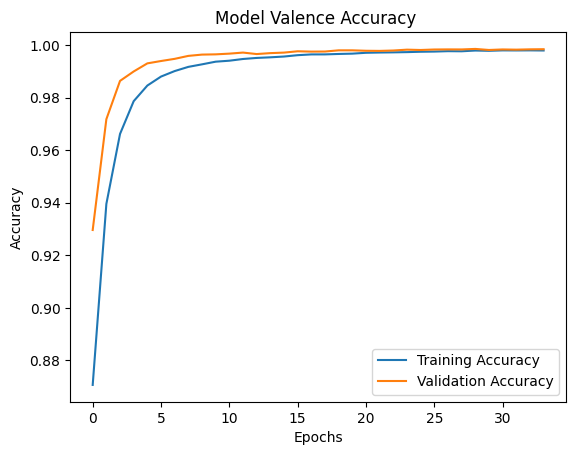

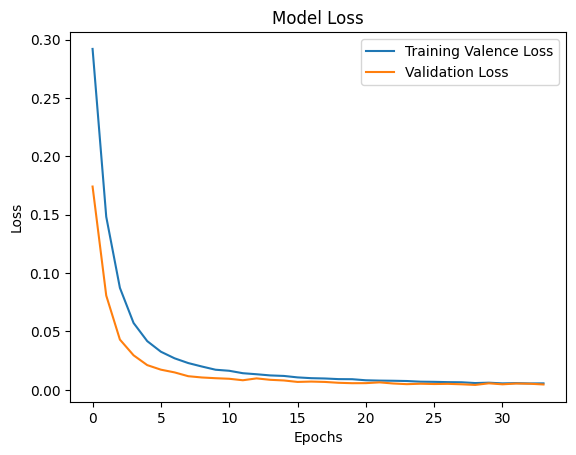

In [ ]:
# Vẽ biểu đồ
# Tải history từ file pickle
with open('/content/drive/MyDrive/DEAP/Save history/history MCIC_Valence_5.pkl', 'rb') as f:
    history_loaded = pickle.load(f)
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho accuracy
plt.plot(history_loaded['accuracy'], label='Training Accuracy')
plt.plot(history_loaded['val_accuracy'], label='Validation Accuracy')
plt.title('Model Valence Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 #Vẽ biểu đồ cho loss
plt.plot(history_loaded['loss'], label='Training Valence Loss')
plt.plot(history_loaded['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

#M1
from keras.layers import Input, Conv1D, BatchNormalization, Activation, AveragePooling1D, Flatten, Dense, Dropout
from keras.layers import concatenate
#from keras.utils.vis_utils import plot_model


intput_shape=(x_train.shape[1], 1) #x_train.shape[1]

input_layer = Input(intput_shape)


conv1 = Conv1D(32, kernel_size=6,padding = 'same',activation='relu') (input_layer)
bn1 = BatchNormalization() (conv1)
pool1 = MaxPooling1D(pool_size=(2)) (bn1)

conv2 = Conv1D(32,kernel_size=6,padding = 'same', activation='relu') (pool1)
bn2 = BatchNormalization() (conv2)
pool2 = MaxPooling1D(pool_size=(2)) (bn2)

conv3 = Conv1D(32,kernel_size=6,padding = 'same', activation='relu') (pool2)
bn3 = BatchNormalization() (conv3)
pool3 = MaxPooling1D(pool_size=(2)) (bn3)

connect1 = concatenate([pool1, pool2, pool3], axis=1)

conv4 = Conv1D(128,kernel_size=6,padding = 'same', activation='relu') (connect1)
bn4 = BatchNormalization() (conv4)
pool4 = MaxPooling1D(pool_size=(2)) (bn4)

flat = Flatten() (pool4)

dense1 = Dense(1024, activation='relu') (flat)
drop1 = Dropout(0.2) (dense1)

dense2 = Dense(256, activation='relu') (drop1)
drop2 = Dropout(0.2) (dense2)

dense3 = Dense(64, activation='relu') (drop2)
drop3 = Dropout(0.2) (dense3)

output_layer = Dense(2, activation='softmax') (drop3) #num_classes

model = Model(input_layer, output_layer)
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Model: "model"

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_38 (Conv1D)          (None, 28, 32)               224       ['input_12[0][0]']            
                                                                                                  
 batch_normalization_35 (Ba  (None, 28, 32)               128       ['conv1d_38[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_23 (MaxPooli  (None, 14, 32)               0         ['batch_normalization_3

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4998/4998 [==============================] - 48s 9ms/step - loss: 0.2045 - accuracy: 0.9105 - val_loss: 0.0950 - val_accuracy: 0.9619
Epoch 2/100
4998/4998 [==============================] - 42s 8ms/step - loss: 0.0702 - accuracy: 0.9723 - val_loss: 0.0402 - val_accuracy: 0.9835
Epoch 3/100
4998/4998 [==============================] - 42s 8ms/step - loss: 0.0447 - accuracy: 0.9829 - val_loss: 0.0521 - val_accuracy: 0.9817
Epoch 4/100
4998/4998 [==============================] - 42s 8ms/step - loss: 0.0341 - accuracy: 0.9873 - val_loss: 0.0307 - val_accuracy: 0.9893
Epoch 5/100
4998/4998 [==============================] - 42s 8ms/step - loss: 0.0293 - accuracy: 0.9892 - val_loss: 0.0263 - val_accuracy: 0.9898
Epoch 6/100
4998/4998 [==============================] - 42s 8ms/step - loss: 0.0251 - accuracy: 0.9910 - val_loss: 0.0156 - val_accuracy: 0.9939
Epoch 7/100
4998/4998 [==============================] - 42s 8ms/step - loss: 0.0223 - accuracy: 0.9919 - val_loss: 0.0167 -

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

def model_M2(input_shape, num_classes, learning_rate):
    input_layer = Input(shape=input_shape)

    # Convolutional Layer 1
    conv1 = Conv1D(16, kernel_size=6, padding='same', activation='relu')(input_layer)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=2)(bn1)

    # Convolutional Layer 2
    conv2 = Conv1D(16, kernel_size=6, padding='same', activation='relu')(pool1)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=2)(bn2)

    # Concatenation of both branches
    connect1 = Concatenate(axis=1)([pool1, pool2])

    # Flatten and dense layers
    flat = Flatten()(connect1)
    dense3 = Dense(32, activation='relu')(flat)
    drop3 = Dropout(0.2)(dense3)
    output_layer = Dense(num_classes, activation='softmax')(drop3)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_shape = (28, 1)  # Replace with your input shape
num_classes = 2       # Replace with your number of classes
learning_rate = 0.001  # Replace with your learning rate

# Create the model
model_M2 = model_M2(input_shape, num_classes, learning_rate)

# Check the model summary
model_M2.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_44 (Conv1D)          (None, 28, 16)               112       ['input_14[0][0]']            
                                                                                                  
 batch_normalization_41 (Ba  (None, 28, 16)               64        ['conv1d_44[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling1d_29 (MaxPooli  (None, 14, 16)               0         ['batch_normalization_4

In [ ]:
H = model_M2.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model_M2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4998/4998 [==============================] - 31s 6ms/step - loss: 0.3348 - accuracy: 0.8490 - val_loss: 0.2359 - val_accuracy: 0.8960
Epoch 2/100
4998/4998 [==============================] - 28s 6ms/step - loss: 0.2356 - accuracy: 0.8942 - val_loss: 0.1763 - val_accuracy: 0.9231
Epoch 3/100
4998/4998 [==============================] - 28s 6ms/step - loss: 0.1989 - accuracy: 0.9100 - val_loss: 0.1488 - val_accuracy: 0.9360
Epoch 4/100
4998/4998 [==============================] - 28s 6ms/step - loss: 0.1767 - accuracy: 0.9207 - val_loss: 0.1342 - val_accuracy: 0.9425
Epoch 5/100
4998/4998 [==============================] - 27s 5ms/step - loss: 0.1625 - accuracy: 0.9274 - val_loss: 0.1234 - val_accuracy: 0.9480
Epoch 6/100
4998/4998 [==============================] - 27s 5ms/step - loss: 0.1520 - accuracy: 0.9320 - val_loss: 0.1128 - val_accuracy: 0.9537
Epoch 7/100
4998/4998 [==============================] - 27s 5ms/step - loss: 0.1442 - accuracy: 0.9350 - val_loss: 0.1037 -

In [ ]:
score = model_M2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 11s 2ms/step - loss: 0.0269 - accuracy: 0.9895
Test loss: 0.0268695205450058
Test accuracy: 0.9895235896110535


In [ ]:
import tensorflow
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, Dense, multiply

class SELayer(tensorflow.keras.layers.Layer):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.global_average_pooling = GlobalAveragePooling1D()
        self.dense_1 = Dense(channel // reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)
        self.dense_2 = Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self, input_tensor):
        # Squeeze operation
        x = self.global_average_pooling(input_tensor)
        x = Reshape((1, -1))(x)

        # Excitation operation
        x = self.dense_1(x)
        x = self.dense_2(x)

        # Scale input tensor
        x = multiply([input_tensor, x])
        return x


In [ ]:
def EEG_ECS(input_shape, num_classes, params):
    input_layer = Input(shape=input_shape)

    # Branch 1
    branch_1 = Conv1D(filters=params['filter_size_branch_1'], kernel_size=params['kernel_size_branch_1'], padding='same', activation='relu')(input_layer)
    branch_1 = BatchNormalization()(branch_1)

    # Branch 2
    branch_2 = Conv1D(filters=params['filter_size_branch_2'], kernel_size=params['kernel_size_branch_2'], dilation_rate=params['dilation_rate_branch_2'], padding='causal', activation='relu')(input_layer)
    branch_2 = BatchNormalization()(branch_2)

    # Combining branches
    merged = Concatenate(axis=-1)([branch_1, branch_2])

    # Adding SELayer
    merged_with_se = SELayer(params['filter_size_branch_1'] + params['filter_size_branch_2'])(merged)

    # Following layers...
    x = Conv1D(filters=params['final_conv_filters'], kernel_size=3, padding='same', activation='relu')(merged_with_se)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Dropout(params['dropout_rate'])(x)

    x = Flatten()(x)
    x = Dense(params['dense_units'], activation='relu')(x)
    x = Dropout(params['dropout_rate'])(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model
params = {
    'filter_size_branch_1': 32,
    'filter_size_branch_2': 32,
    'kernel_size_branch_1': 3,
    'kernel_size_branch_2': 5,
    'dilation_rate_branch_2': 2,
    'final_conv_filters': 64,
    'dense_units': 2048,
    'dropout_rate': 0.1221674089781148,
    'learning_rate': 0.00012516264788334488
}
# Update parameters with SELayer and compile the model as before
model_ECS = EEG_ECS(input_shape, num_classes, params)
model_ECS.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture
model_ECS.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_46 (Conv1D)          (None, 28, 32)               128       ['input_15[0][0]']            
                                                                                                  
 conv1d_47 (Conv1D)          (None, 28, 32)               192       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_43 (Ba  (None, 28, 32)               128       ['conv1d_46[0][0]']           
 tchNormalization)                                                                         

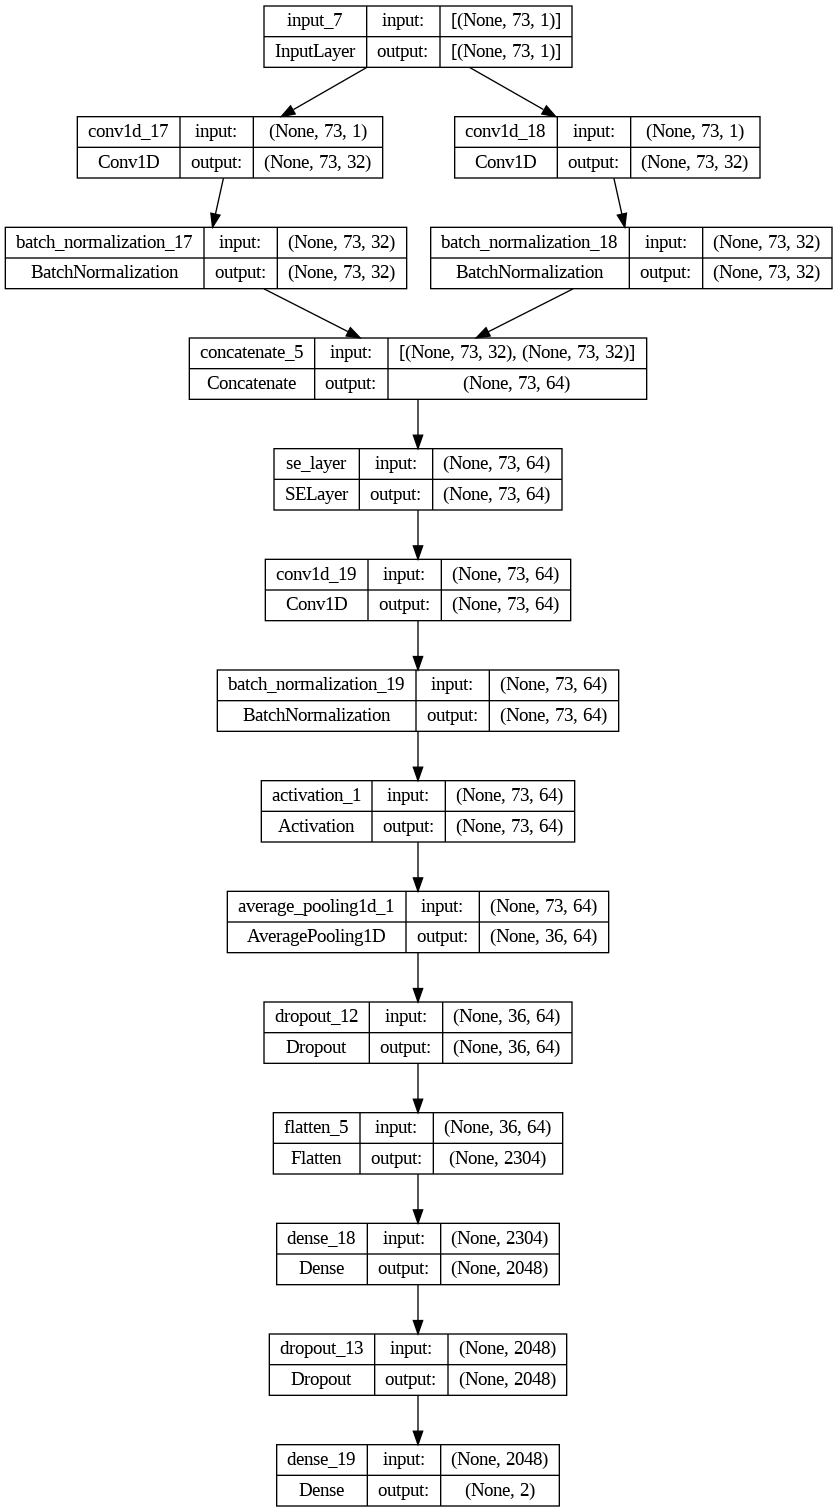

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_ECS, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
H = model_ECS.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model_ECS.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4998/4998 [==============================] - 41s 8ms/step - loss: 0.2911 - accuracy: 0.8709 - val_loss: 0.1659 - val_accuracy: 0.9330
Epoch 2/100
4998/4998 [==============================] - 38s 8ms/step - loss: 0.1456 - accuracy: 0.9404 - val_loss: 0.0770 - val_accuracy: 0.9732
Epoch 3/100
4998/4998 [==============================] - 38s 8ms/step - loss: 0.0839 - accuracy: 0.9676 - val_loss: 0.0445 - val_accuracy: 0.9854
Epoch 4/100
4998/4998 [==============================] - 38s 8ms/step - loss: 0.0553 - accuracy: 0.9791 - val_loss: 0.0272 - val_accuracy: 0.9912
Epoch 5/100
4998/4998 [==============================] - 38s 8ms/step - loss: 0.0408 - accuracy: 0.9848 - val_loss: 0.0200 - val_accuracy: 0.9935
Epoch 6/100
4998/4998 [==============================] - 40s 8ms/step - loss: 0.0319 - accuracy: 0.9882 - val_loss: 0.0147 - val_accuracy: 0.9951
Epoch 7/100
4998/4998 [==============================] - 39s 8ms/step - loss: 0.0258 - accuracy: 0.9904 - val_loss: 0.0129 -

In [ ]:
score = model_ECS.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4880/4880 [==============================] - 16s 3ms/step - loss: 0.0039 - accuracy: 0.9988
Test loss: 0.0039006585720926523
Test accuracy: 0.9988089203834534


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, Activation, AveragePooling1D, Concatenate

def CNN_Sid(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Example usage:
input_shape = (28, 1)  # Replace with your input shape
num_classes = 2  # Replace with your number of classes

model_Sid = CNN_Sid(input_shape, num_classes)
model_Sid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_Sid.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 28, 128)           512       
                                                                 
 batch_normalization_48 (Ba  (None, 28, 128)           512       
 tchNormalization)                                               
                                                                 
 max_pooling1d_34 (MaxPooli  (None, 14, 128)           0         
 ng1D)                                                           
                                                                 
 conv1d_53 (Conv1D)          (None, 14, 128)           49280     
                                                                 
 batch_normalization_49 (Ba  (None, 14, 128)           512       
 tchNormalization)                                               
                                                      

In [ ]:
H = model_Sid.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4998/4998 [==============================] - 37s 7ms/step - loss: 0.2829 - accuracy: 0.8738 - val_loss: 0.1565 - val_accuracy: 0.9320
Epoch 2/100
4998/4998 [==============================] - 33s 7ms/step - loss: 0.1352 - accuracy: 0.9441 - val_loss: 0.0913 - val_accuracy: 0.9613
Epoch 3/100
4998/4998 [==============================] - 34s 7ms/step - loss: 0.0881 - accuracy: 0.9644 - val_loss: 0.0581 - val_accuracy: 0.9757
Epoch 4/100
4998/4998 [==============================] - 33s 7ms/step - loss: 0.0666 - accuracy: 0.9731 - val_loss: 0.0450 - val_accuracy: 0.9810
Epoch 5/100
4998/4998 [==============================] - 32s 6ms/step - loss: 0.0555 - accuracy: 0.9774 - val_loss: 0.0414 - val_accuracy: 0.9826
Epoch 6/100
4998/4998 [==============================] - 33s 7ms/step - loss: 0.0494 - accuracy: 0.9801 - val_loss: 0.0390 - val_accuracy: 0.9832
Epoch 7/100
4998/4998 [==============================] - 34s 7ms/step - loss: 0.0450 - accuracy: 0.9822 - val_loss: 0.0441 -

In [ ]:
score = model_Sid.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'model_Sid' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras

def CNN_LSTM_Sid(input_shape, num_classes):
    model = Sequential()

    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.6))

    model.add(LSTM(units=256, return_sequences=True))
    model.add(Dropout(0.6))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.6))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(units=32))
    model.add(Dropout(0.4))

    model.add(Dense(units=16))
    model.add(Activation('relu'))

    model.add(Dense(units=num_classes))
    model.add(Activation('softmax'))

    # Compile the model
    model.compile(optimizer="adam", loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

    return model

# Example usage
input_shape = (73, 1)  # Replace with your input shape
num_classes = 2  # Replace with your number of classes

model_CNN_LSTM_Sid = CNN_LSTM_Sid(input_shape, num_classes)

# Training the model is not part of the function, so it's executed separately.
# Replace x_train, y_train, x_test, y_test with your datasets.
#history = model.fit(x_train, y_train, epochs=200, batch_size=256, verbose=1, validation_data=(x_test, y_test))

# Optionally, you can summarize the model architecture
model_CNN_LSTM_Sid.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 73, 256)           133120    
 al)                                                             
                                                                 
 dropout_23 (Dropout)        (None, 73, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 73, 256)           525312    
                                                                 
 dropout_24 (Dropout)        (None, 73, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 73, 64)            82176     
                                                                 
 dropout_25 (Dropout)        (None, 73, 64)            0         
                                                      

In [ ]:
H = model_CNN_LSTM_Sid.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4685/4685 [==============================] - 159s 32ms/step - loss: 0.4608 - accuracy: 0.7882 - val_loss: 0.3861 - val_accuracy: 0.8353
Epoch 2/100
4685/4685 [==============================] - 151s 32ms/step - loss: 0.3089 - accuracy: 0.8598 - val_loss: 0.2194 - val_accuracy: 0.9023
Epoch 3/100
4685/4685 [==============================] - 152s 32ms/step - loss: 0.1716 - accuracy: 0.9281 - val_loss: 0.0806 - val_accuracy: 0.9682
Epoch 4/100
4685/4685 [==============================] - 153s 33ms/step - loss: 0.0984 - accuracy: 0.9602 - val_loss: 0.0443 - val_accuracy: 0.9818
Epoch 5/100
4685/4685 [==============================] - 152s 32ms/step - loss: 0.0747 - accuracy: 0.9699 - val_loss: 0.0335 - val_accuracy: 0.9843
Epoch 6/100
4685/4685 [==============================] - 152s 33ms/step - loss: 0.0630 - accuracy: 0.9749 - val_loss: 0.0421 - val_accuracy: 0.9813
Epoch 7/100
4685/4685 [==============================] - 153s 33ms/step - loss: 0.0542 - accuracy: 0.9782 - val_

KeyboardInterrupt: 

In [ ]:
#MCIS
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, AveragePooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam

def EEG_MCIS(input_shape, num_classes, params):
    input_layer = Input(shape=input_shape)

    # Branch 1
    branch_1 = Conv1D(filters=params['filter_size_branch_1'] // 2, # Giảm số lượng bộ lọc
                      kernel_size=params['kernel_size_branch_1'],
                      padding='same', activation='relu')(input_layer)
    branch_1 = BatchNormalization()(branch_1)

    # Branch 2
    branch_2 = Conv1D(filters=params['filter_size_branch_2'] // 2, # Giảm số lượng bộ lọc
                      kernel_size=params['kernel_size_branch_2'],
                      dilation_rate=params['dilation_rate_branch_2'],
                      padding='causal', activation='relu')(input_layer)
    branch_2 = BatchNormalization()(branch_2)

    # Combining branches
    merged = Concatenate(axis=-1)([branch_1, branch_2])

    # Tiếp tục với cấu trúc giống như trước nhưng với số lượng bộ lọc ít hơn
    x = Conv1D(filters=params['final_conv_filters'] // 2, kernel_size=3, padding='same', activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Dropout(params['dropout_rate'])(x)

    # Giảm số lượng đơn vị trong các lớp Dense
    x = Flatten()(x)
    x = Dense(params['dense_units'] // 4, activation='relu')(x) # Giảm số lượng đơn vị
    x = Dropout(params['dropout_rate'])(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

params = {
    'filter_size_branch_1': 16, # Đã giảm từ 32 xuống 16
    'filter_size_branch_2': 16, # Đã giảm từ 32 xuống 16
    'kernel_size_branch_1': 3,
    'kernel_size_branch_2': 5,
    'dilation_rate_branch_2': 2,
    'final_conv_filters': 32, # Đã giảm từ 64 xuống 32
    'dense_units': 512, # Đã giảm từ 2048 xuống 512
    'dropout_rate': 0.5, # Tăng dropout_rate lên một chút
    'learning_rate': 0.0001,
}

# Khởi tạo mô hình
input_shape = (28, 1)
num_classes = 2
model= EEG_MCIS(input_shape, num_classes, params)
model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị tóm tắt mô hình
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 1)]              0         []                            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 28, 8)                32        ['input_3[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 28, 8)                48        ['input_3[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 28, 8)                32        ['conv1d_5[0][0]']            
 chNormalization)                                                                           

In [ ]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks= callbacks_list)
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
4998/4998 [==============================] - 43s 8ms/step - loss: 0.2911 - accuracy: 0.8698 - val_loss: 0.1790 - val_accuracy: 0.9233
Epoch 2/100
4998/4998 [==============================] - 40s 8ms/step - loss: 0.1712 - accuracy: 0.9266 - val_loss: 0.1070 - val_accuracy: 0.9572
Epoch 3/100
4998/4998 [==============================] - 38s 8ms/step - loss: 0.1265 - accuracy: 0.9469 - val_loss: 0.0734 - val_accuracy: 0.9722
Epoch 4/100
4998/4998 [==============================] - 40s 8ms/step - loss: 0.1041 - accuracy: 0.9562 - val_loss: 0.0595 - val_accuracy: 0.9769
Epoch 5/100
4998/4998 [==============================] - 39s 8ms/step - loss: 0.0907 - accuracy: 0.9619 - val_loss: 0.0517 - val_accuracy: 0.9795
Epoch 6/100
4998/4998 [==============================] - 41s 8ms/step - loss: 0.0814 - accuracy: 0.9661 - val_loss: 0.0527 - val_accuracy: 0.9777
Epoch 7/100
4998/4998 [==============================] - 43s 9ms/step - loss: 0.0750 - accuracy: 0.9687 - val_loss: 0.0468 -

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3904/3904 [==============================] - 14s 4ms/step - loss: 0.0137 - accuracy: 0.9951
Test loss: 0.013691742904484272
Test accuracy: 0.9951011538505554


In [ ]:
#import pickle

# Lưu history.history vào file pickle
with open('/content/drive/MyDrive/DEAP/Save history/history MCICmini_Valence_5.pkl', 'wb') as f:
    pickle.dump(H.history, f)

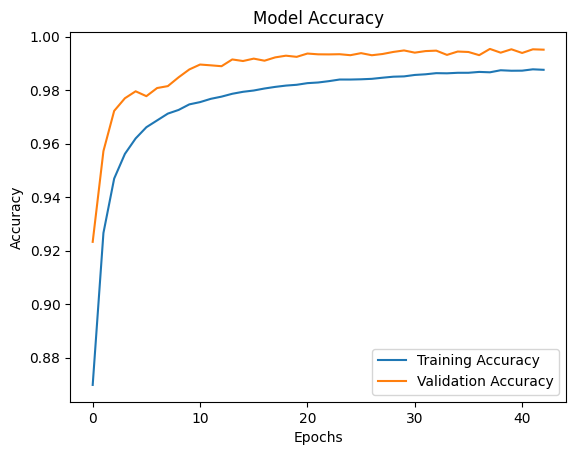

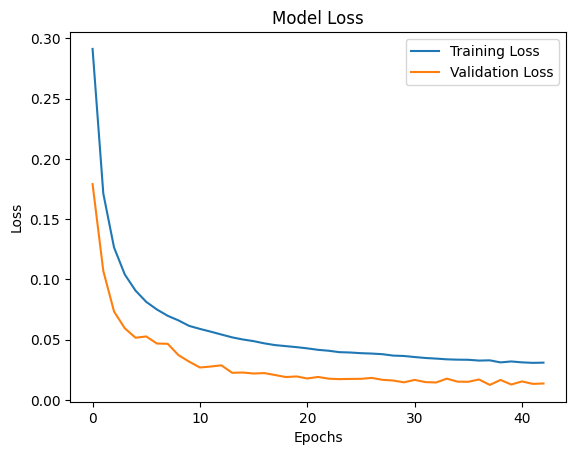

In [ ]:
# Vẽ biểu đồ
# Tải history từ file pickle
with open('/content/drive/MyDrive/DEAP/Save history/history MCICmini_Valence_5.pkl', 'rb') as f:
    history_loaded = pickle.load(f)
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho accuracy
plt.plot(history_loaded['accuracy'], label='Training Accuracy')
plt.plot(history_loaded['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 #Vẽ biểu đồ cho loss
plt.plot(history_loaded['loss'], label='Training Loss')
plt.plot(history_loaded['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()